In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from func import ShopeeDataset, device, torch, np, f1_score_cal, display_df, path, path_img, get_data
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from efficientnet_pytorch import EfficientNet
import gc
import wandb 

In [2]:
# input
df = get_data(path / 'train.csv')
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_129225211, train_2278313361]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3423213080, train_3386243561]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2406599165, train_3342059966]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml


In [3]:
dataset_data = ShopeeDataset(csv=df, train=True)
data_loader = DataLoader(dataset_data, batch_size=16, num_workers=4)

print(f"Dataset Len: {len(dataset_data):,}\nImage Shape [0]: {dataset_data[0][0].shape}")

Dataset Len: 34,250
Image Shape [0]: torch.Size([3, 256, 256])


In [4]:
image_embeddings_path = path / 'all_image_embeddings.npy'
rerun = True
wandb.init(project='shopee-kaggle', name='image_embeddings')

if rerun:
    # Run
    
    model_name = 'efficientnet-b0'
    model_effnet = EfficientNet.from_name(model_name).to(device)

    wandb.log({'Model': model_name})
    print(model_name, device)

    embeddings = []
    with torch.no_grad():
        for image, label in tqdm(data_loader):
            image = image.to(device)
            img_embeddings = model_effnet(image)
            img_embeddings = img_embeddings.detach().cpu().numpy()
            embeddings.append(img_embeddings)
    all_image_embeddings = np.concatenate(embeddings)
    print(f"image_embeddings shape: {all_image_embeddings.shape}")

    # Save
    np.save(image_embeddings_path, all_image_embeddings)

    # Clean memory
    del model_effnet
    _ = gc.collect()
    
else:
    # load
    all_image_embeddings = np.load(image_embeddings_path)
    
artifact = wandb.Artifact(name='image_embeddings', type='dataset')
artifact.add_file(image_embeddings_path)
wandb.log_artifact(artifact)
wandb.log({'Shape of Image embeddings': all_image_embeddings.shape})

wandb: Currently logged in as: kevinkhang (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


efficientnet-b0 cuda


100%|██████████| 2141/2141 [01:24<00:00, 25.45it/s]


image_embeddings shape: (34250, 1000)


In [5]:
wandb.log({"n_neighbors" : 50})

knn_model = NearestNeighbors(n_neighbors=50)
knn_model.fit(all_image_embeddings)

# Creating the splits, to prevent memory errors
predictions = []
CHUNK = 1024 * 4  ### 4096

SPLITS = len(all_image_embeddings) // CHUNK
if len(all_image_embeddings) % CHUNK != 0: SPLITS += 1
print(f'Total Splits: {SPLITS}')

# Making the prediction
print('Finding Similar Images ...')
for no in range(SPLITS):
    a = no * CHUNK
    b = min((no + 1) * CHUNK, len(all_image_embeddings))
    print(f'CHUNK: {a} - {b}')
    
    distances, indices = knn_model.kneighbors(all_image_embeddings[a:b,])
    
    for k in range(b-a):
        index = np.where(distances[k, ] < 6.0)[0]
        split = indices[k, index]
        pred = df.iloc[split]['posting_id'].values.tolist()
        predictions.append(pred)

        
# Clean environment
del knn_model, distances
_ = gc.collect()

Total Splits: 9
Finding Similar Images ...
CHUNK: 0 - 4096
CHUNK: 4096 - 8192
CHUNK: 8192 - 12288
CHUNK: 12288 - 16384
CHUNK: 16384 - 20480
CHUNK: 20480 - 24576
CHUNK: 24576 - 28672
CHUNK: 28672 - 32768
CHUNK: 32768 - 34250


In [6]:
df['img_pred'] = predictions
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit,img_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_129225211, train_2278313361]",paper bag victoria secret,[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3423213080, train_3386243561]","double tape 3m vhb 12 mm x 4,5 m original / do...",[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr,"[train_2288590299, train_3630936139, train_366..."
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2406599165, train_3342059966]",daster batik lengan pendek - motif acak / camp...,"[train_2406599165, train_2594893028, train_254..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_921438619, train_3369186413]",nescafe \xc3\x89clair latte 220ml,"[train_3369186413, train_413507128, train_1122..."


In [7]:
df['f1_score'] = [f1_score_cal(i, v) for i, v in df[['target', 'img_pred']].values]
print(f"CV score for baseline = {df['f1_score'].mean():.3f}")

CV score for baseline = 0.093


Text(0, 0.5, '')

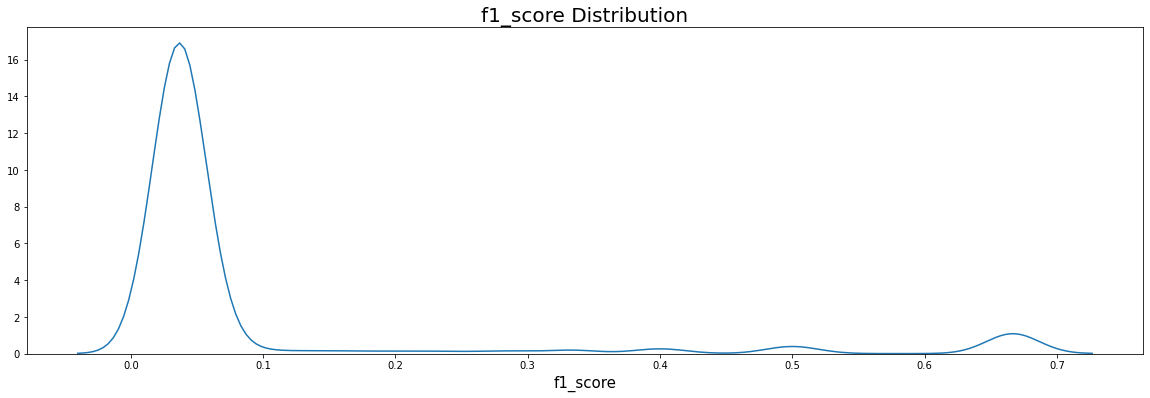

In [8]:
plt.figure(figsize = (20, 6))

plot = sns.kdeplot(x = df["f1_score"])
plt.title("f1_score Distribution", fontsize=20)
plt.xlabel("f1_score", fontsize=15)
plt.ylabel("")

In [9]:
custom_data = [[s] for s in df['f1_score']]
table = wandb.Table(data=custom_data, columns=["f1_score"])
wandb.log({'f1_hist': wandb.plot.histogram(table, "f1_score", title="f1_score image match")})
wandb.finish()

n_neighbors,▁
Model,efficientnet-b0
n_neighbors,50


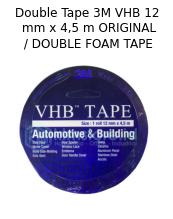

In [10]:
test_id = 'train_3386243561'
tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['img_pred'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left')

display_df(tmp, path_img)

In [12]:
df[['posting_id', 'img_pred', 'f1_score']].to_feather(path / 'img_pred.ftr')